# Методы оптимизации.
## Домашнее задание.
### Илья Игашов, 591 группа.


# ==========================================================
# Задача на МНК (0.4 балла)

In [1]:
from math import sin
import numpy as np

"""Пусть физический закон описывается зависимостью 
некоторого измеряемого значения y(x, a) 
от времени и координаты x при параметрах a:"""
def y(t,a): 
    return a[2]*sin(t)+a[1]*t +a[0]
    
"""
Дан набор координат t размера m, значения распределены равномерно). Пусть m = 200.
"""
m=200
t=[i*10.0/m for i in range(m)]


"""Для каждого момента времени t сгенерируйте соответствующее 
значение y(t,a) при некоторых параметрах  a_0, a_1, a_2. Для примера: """
a=[10,100,1000]

def get_y (a, sigma):
    """Результаты измерений отличаются от истинных значений в силу действия случайной аддитивной помехи 
    (случайность подчиняется нормальному закону распределения N(0, σ))"""
    y_real=np.array([y(i,a) for i in t])
    y_corr=y_real+np.random.normal(0,sigma,m)
    return y_real, y_corr

#todo -выбрать параметр
sigma=0.5

#генерация значений. изначальные и с помехами
y_real, y_corr= get_y(a,sigma)

# Методы оценки параметров

## Метод 1: Сумма квадратов невязок будет минимальна

Введем обозначения:
$$
A = \left(\begin{array}{cc}  
     1 & t_1 & sin{t_1} \\ 
     1 & t_2 & sin{t_2} \\
               & ... &   \\
     1 & t_m & sin{t_m}
     \end{array}\right),
$$

$$
\vec{a} = (a_1, a_2, a_3)^T - параметры,
$$
$$
\vec{b} = (b_1, \dots, b_m)^T - измеренные \ значения.
$$

Требуется минимизировать сумму квадратов невязок, то есть $\|A\vec{a} - \vec{b} \|_2 \rightarrow \min$. 

Эту задачу решает метод наименьших квадратов:
$$\vec{a} = (A^T A)^{-1} A^T \vec{b}.$$

## Метод 2: Сумма абсолютных значений невязок будет минимальна

Рассмотрим задачу линейного программирования:

$$\sum x_i \to min,$$
$$A\vec{a} - \vec{x} \leqslant \vec{b},$$
$$-A\vec{a} - \vec{x} \leqslant -\vec{b}.$$

Она эквивалентна следующей:

$$|a_3 \sin t_i + a_2 t_i + a_1 - y_i^{наб}| < x_i$$

$$\sum x_i \to \min$$

А это и есть минимизация суммы абсолютных значений невязок ($x_i$ - абсолютная ошибка $i$-го эксперимента).

Задача ЛП в матричном виде:
$$\vec{x} = (a_3, a_2, a_1, x_1, \dots , x_m)^T,$$ 
$$\vec{c} = (0, 0, 0, 1, \dots, 1)^T,$$
$$\vec{c}^T\vec{x} \rightarrow \min,$$ 

$$
        \left(\begin{array}{cc}  
           A & -E \\ 
           -A & - E
        \end{array}\right) x 
      \leq
        \left(\begin{array}{c}  
           y \\  
           -y  
        \end{array}\right).
$$

## Метод 3: Максимальное обсолютное значение невязки будет минимально

Рассмотрим задачу линейного программирования: 

$$e \rightarrow \min,$$
$$A \vec{a} - e \leqslant \vec{b},$$
$$-A\vec{a} - e \leqslant -\vec{b}.$$

Она эквивалентна следующей:

$$|a_3 \sin t_i + a_2t_i + a_1 - y_i^{наб}| < e \ \forall i,$$
$$e \rightarrow \min$$

А это и есть минимизация максимальной ошибки (обозначим её через $e$).

Задача ЛП в матричном виде:

$$\vec{x} = (a_1, a_2, a_3, e)^T,$$
$$\vec{c} = (0, 0, 0, 1)^T,$$
$$\vec{c}^T\vec{x} \rightarrow \min,$$ 

$$ 
        \left(\begin{array}{cc}  
            A &
            \left(\begin{array}{c}  
               -1\\
               \vdots \\
               -1 
            \end{array}\right)\\  
            -A &
            \left(\begin{array}{c}  
               -1\\
               \vdots \\
               -1 
            \end{array}\right)\\ 
        \end{array}\right) x 
      \leq
        \left(\begin{array}{c}  
           y \\  
           -y  
        \end{array}\right)
$$

In [2]:
from scipy.optimize import linprog

def solve_lin_prog(A, b, c, method='blend', lbound=-np.inf):
    # По-хорошему, тут нужно использовать мою функцию из следующей задачи, но она там не полностью доделана,
    # потому что там нет двухфазного симплекс метода :(
    result = linprog(c, A_ub=A, b_ub=b, 
                    bounds=[(lbound,  np.inf) for i in range(A.shape[1])],
                    options=dict(bland=(method=='blend'), tol=1e-8, maxiter=10 ** 8))
    return result.x, result.fun, result.nit

In [3]:
from math import sin
import numpy as np

def get_params (y_corr, t, method=0):
    """
    По сгенерированному набору точек y_corr дайте оценку параметрам a
    закона с учетом знания общей формулы тремя различными способами:
    •	method=0 -> сумма квадратов невязок будет минимальна.
    •	method=1 -> сумма абсолютных значений невязок будет минимальна.
    •	method=2 -> максимальное абсолютное значение невязки будет минимально.
    
    #todo - написать ф-ю
    """
    m = len(t) # Количество строк матрицы A.
    n = 3      # Количество столбцов матрицы A.
    b = y_corr # Измеренные значения.
    A = np.array([
        [1, i, sin(i)]
        for i in t
    ])
    
    if method == 0:
        # Сумма квадратов невязок будет минимальна.
        return (np.linalg.inv(A.T @ A) @ A.T @ b)
    elif method == 1: 
        # Сумма абсолютных значений невязок будет минимальна.
        c = np.append(np.zeros(n), np.ones(m))
        y = np.append(b, -b)
        matrix = np.vstack((np.hstack((A, -np.eye(m))), np.hstack((-A, -np.eye(m)))))
        x, best, n_iter = solve_lin_prog(matrix, y, c)
        return x[:3]
    elif method == 2:
        # Максимальное абсолютное значение невязки будет минимально.
        c = np.zeros(n + 1)
        c[-1] = 1
        y = np.append(b, -b)
        matrix = np.vstack((A, -A))
        matrix = np.insert(matrix, n, -1, axis=1)
        x, best, n_iter = solve_lin_prog(matrix, y, c)
        return x[:3]

In [4]:
get_params(y_corr, t, method=0)

array([    9.9572208 ,    99.99796032,  1000.03245156])

In [5]:
get_params(y_corr, t, method=1)

array([    9.98376733,    99.99365809,  1000.01385017])

In [6]:
get_params(y_corr, t, method=2)

array([   10.1524106 ,    99.96912866,  1000.14168806])

## Задание 1 (0.2 балла)
1.	Постройте в одной координатной плоскости графики у(t, a) и  оценочные значения y(t,a*) для всех 3 методов

2.	Вычислите как отличается каждый из оценочных параметров от своего истинного значения. Как меняется это отличие при изменении σ?
3.	Скорректируйте y_corr[0]  и y_corr[-1] пусть одно из них будет на 50 больше, а другое на 50 меньше. Постройте новые оценочные значения параметров  и соответствующие графики. Какая из оценок получилась более устойчивой к выбросам?

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

In [8]:
def plotting(t, a, sigma, get_y=get_y):
    y_real, y_corr = get_y(a, sigma)
    a_est = np.array([get_params(y_corr, t, method=i) for i in range(3)])
    y_est = np.array([
            [y(i, a) for i in t]
            for a in a_est
        ])
    
    plt.figure(figsize=(14,8))
    plt.plot(t, y_real, label="y(t,a)")
    for i in range(3):
        plt.plot(t, y_est[i], label="method %d" % i)
    plt.scatter(t, y_corr, label="y_corr", alpha=0.4)
    plt.legend()
    plt.title("$\sigma = %.3f$" % sigma)
    plt.xlabel("t")
    plt.ylabel("y")
    plt.xlim(min(t) - 0.5, max(t) + 0.5)
    plt.show()

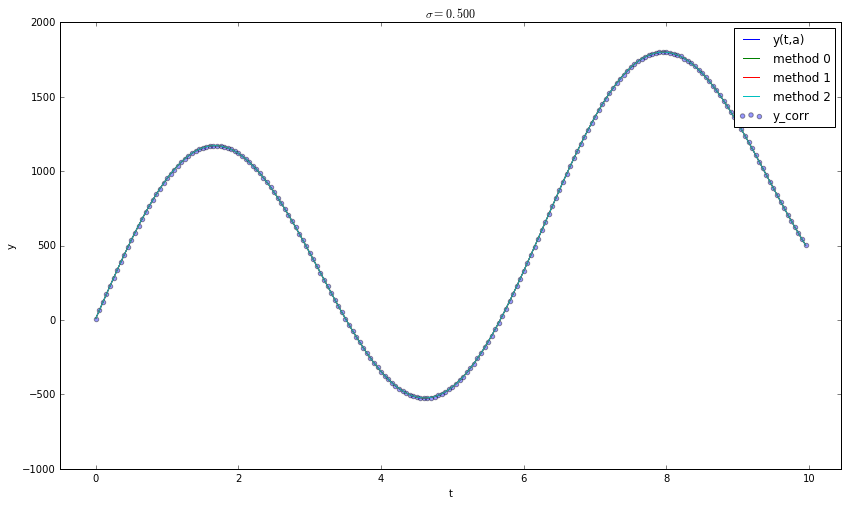

In [9]:
# 1.
sigma=0.5
plotting(t, a, sigma)

Видим, что при малом $\sigma$ все три метода предсказывают довольно точно.

Посмотрим, что будет при больших $\sigma$.

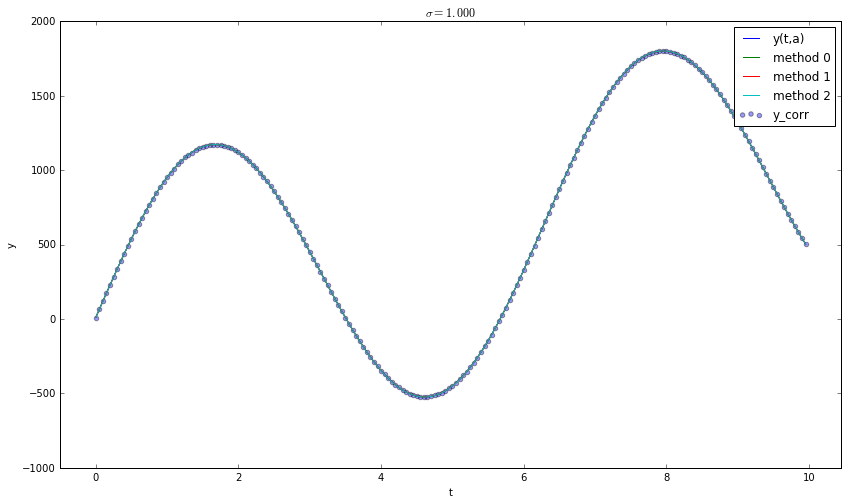

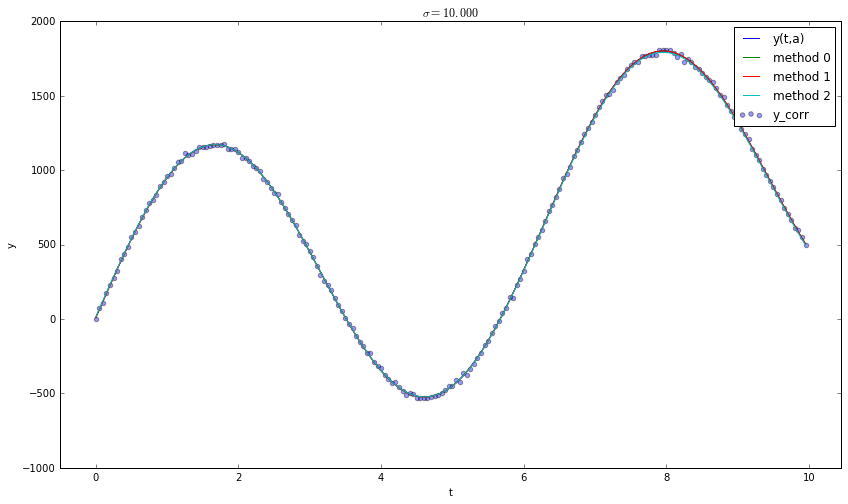

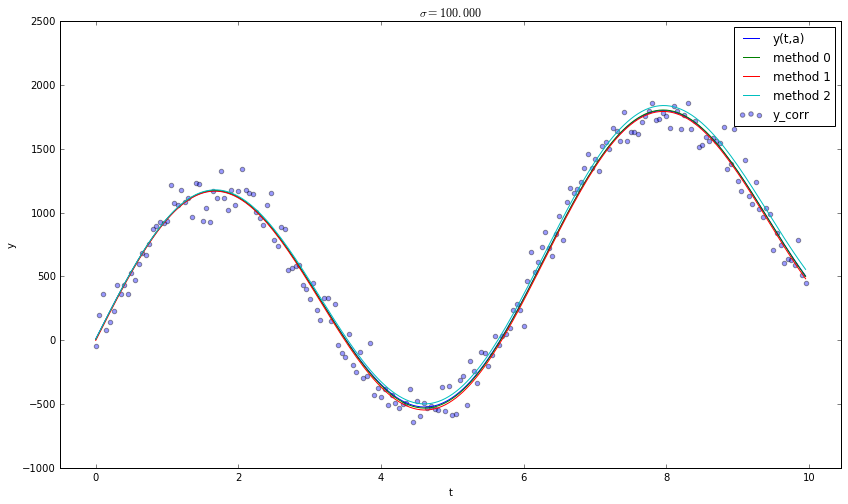

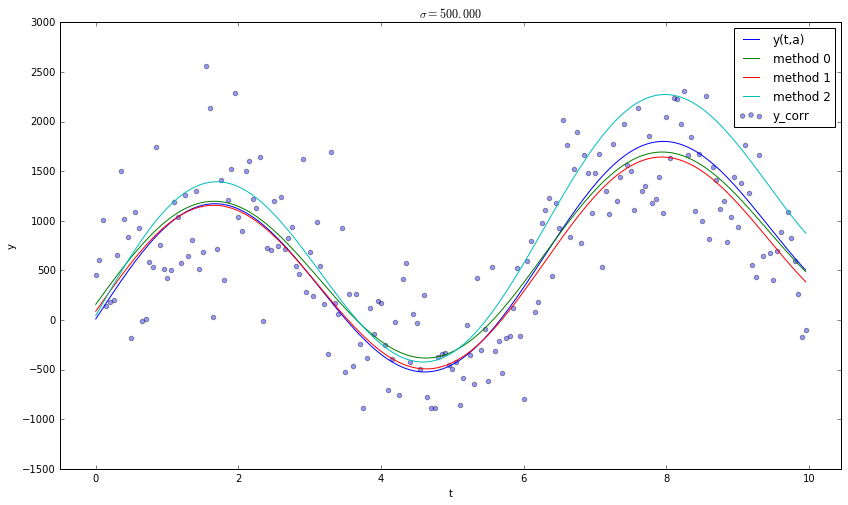

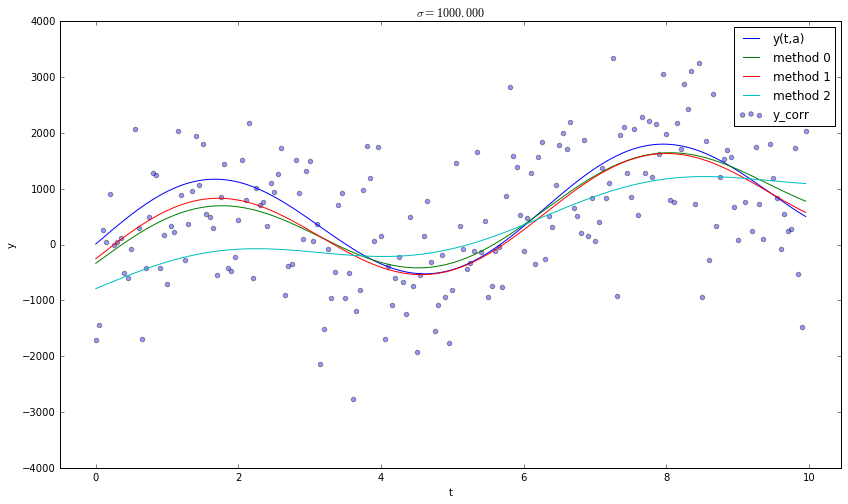

In [11]:
# 2.
for sigma in [1, 10, 100, 500, 1000]:
    plotting(t, a, sigma)

Как видно из графиков, наиболее восприимчивым к разбросу в эмпирических значениях оказался метод 3 (минимизация максимума), который при большой дисперсии оказывается наиболее неточным из всех.

In [12]:
def error(t, a, sigma, get_y=get_y):
    y_real, y_corr = get_y(a, sigma)
    a_est = np.array([get_params(y_corr, t, method=i) for i in range(3)])
    y_est = np.array([
            [y(i, a) for i in t]
            for a in a_est
        ])
    err = []
    for i in range(3):
        err.append(abs(y_est[i] - y_real).mean())
    return np.array(err)

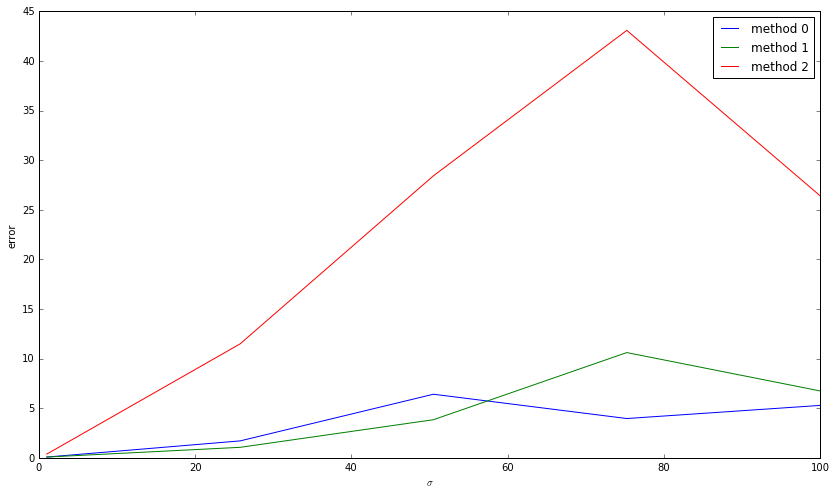

In [16]:
sigmas = np.linspace(1, 100, 5)
plt.figure(figsize=(14,8))
errs = np.array([error(t, a, sigma) for sigma in sigmas])
for i in range(3):
    plt.plot(sigmas, errs[:,i], label="method %d" % i)
plt.legend()
plt.ylabel("error")
plt.xlabel("$\sigma$")
plt.show()

Этот график отклонения предсказанного значения от истинного в зависимоти от $\sigma$ также показывает, что метод 3 минимизации максимума наиболее ненадежен.

In [17]:
# 3.
def get_y_changed (a, sigma):
    y_real=np.array([y(i,a) for i in t])
    y_corr=y_real+np.random.normal(0,sigma,m)
    y_corr[0] -= 50
    y_corr[-1] += 50
    return y_real, y_corr

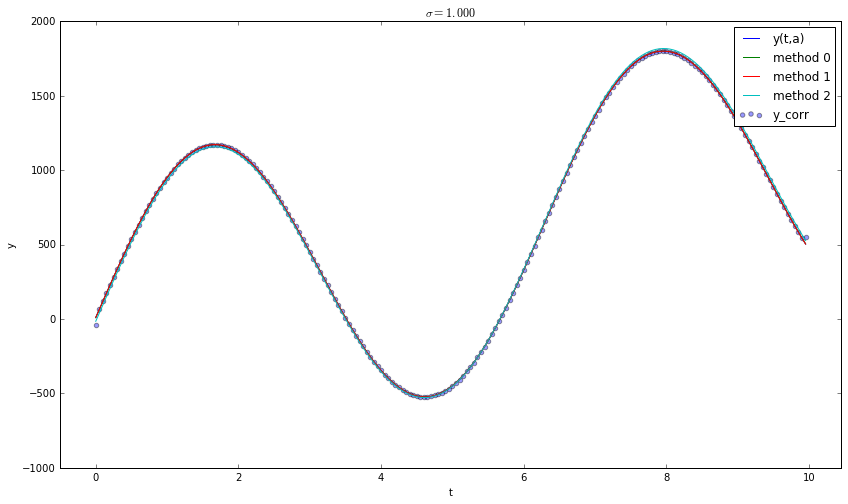

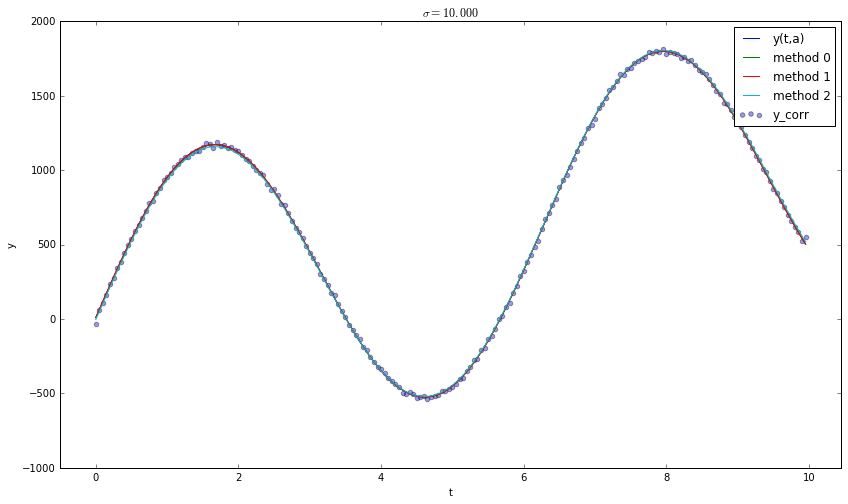

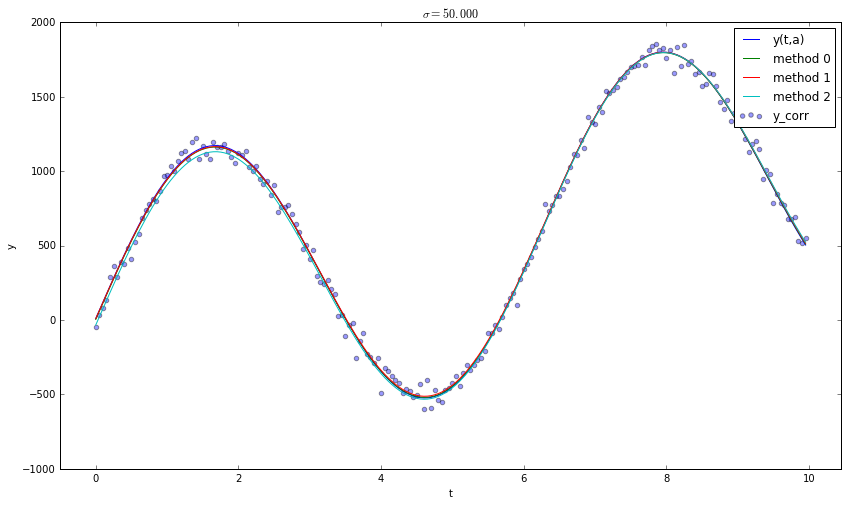

In [18]:
for sigma in [1, 10, 50]:
    plotting(t, a, sigma, get_y=get_y_changed)

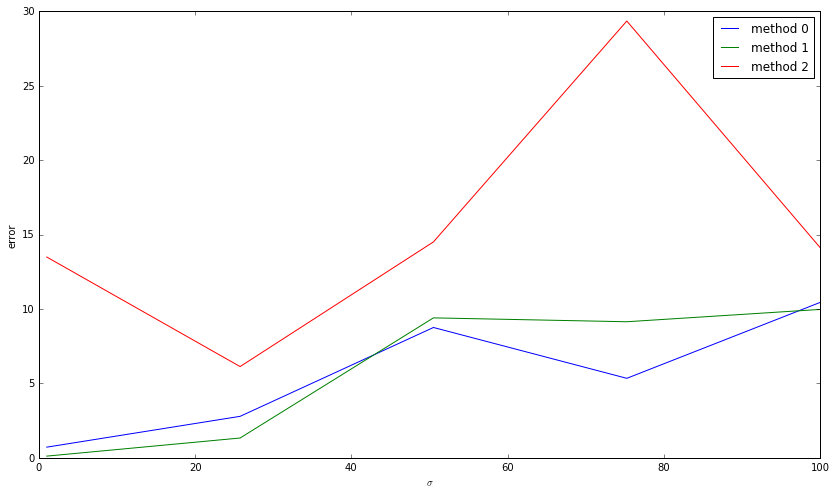

In [19]:
sigmas = np.linspace(1, 100, 5)
plt.figure(figsize=(14,8))
errs = np.array([error(t, a, sigma, get_y=get_y_changed) for sigma in sigmas])
for i in range(3):
    plt.plot(sigmas, errs[:,i], label="method %d" % i)
plt.legend()
plt.ylabel("error")
plt.xlabel("$\sigma$")
plt.show()

## Задание 2 (0.2 балла)
Возьмем случайную матрицу A  200x80 и случайный вектор b из распределения N(0,1). 

1. Решите переопределенную систему тремя способами, минимизируя l1, l2 и linf нормы вектора b – Ax.
2. Постройте распределение ошибок для каждого решения.
3. Какими свойствами обладают распределения?

In [20]:
def solve(A, b, c, method=1):
    m = A.shape[0]
    n = A.shape[1]
    if method == 0:
        # Сумма квадратов невязок будет минимальна.
        return (np.linalg.inv(A.T @ A) @ A.T @ b)
    elif method == 1: 
        # Сумма абсолютных значений невязок будет минимальна.
        c = np.append(np.zeros(n), np.ones(m))
        y = np.append(b, -b)
        matrix = np.vstack((np.hstack((A, -np.eye(m))), np.hstack((-A, -np.eye(m)))))
        x, best, n_iter = solve_lin_prog(matrix, y, c)
        return x[:3]
    elif method == 2:
        # Максимальное абсолютное значение невязки будет минимально.
        c = np.zeros(n + 1)
        c[-1] = 1
        y = np.append(b, -b)
        matrix = np.vstack((A, -A))
        matrix = np.insert(matrix, n, -1, axis=1)
        x, best, n_iter = solve_lin_prog(matrix, y, c)
        return x[:3]

In [21]:
def norm(vect, method=0):
    if method == 0:
        return (vect * vect).sum()
    elif method == 1:
        return (np.abs(vect)).sum()
    elif method == 2:
        return (np.abs(vect)).max()

In [22]:
runs = 10
errors = [
    [norm(solve(np.random.normal(0,1,(200,80)),
                 np.random.normal(0,1,200),
                 method), method=method) for i in range(runs)]
    for method in range(3)
    ]

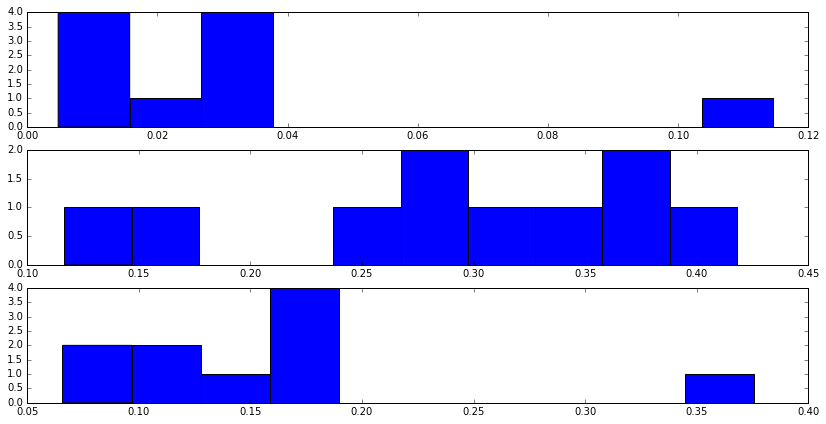

In [23]:
errors = np.array(errors)
plt.figure(figsize=(14,7))
for method in range(3):
    plt.subplot(310 + method + 1)
    plt.hist(errors[method])
plt.show()

# ============================================================
# Задача на Симплекс метод

## 1) На вход Вашему функцию должны приходить:

0. число переменных = n
1. матрица A (n x m) (tsv, вещественные числа)
2. вектор  b  ограничений типа неравнство
4. вектор c функции полезности для задачи max cx 
5. алгоритм выбора входящей переменной (правило Бленда, Лексикографический метод)
6. (не обязательный параметр) стартовую базисную точку

## 2) На выход программа должна выдавать:

### Обязательная часть (0.7 баллов):
0. Ответ и оптимальную точку при положительных компонентах вектора b
1. Количество итераций потребовавшихся для решения задачи
2. при n=2 выдавать процесс решения (draw=True)
3. Напишите программу которая будет отвечать на вопрос оптимально ли приведенное решение, например


### Дополнительная часть  (0.4 балл):
0. Максимально использовать матричные вычисления (0.2 балла)
1. Работать в случае отрицательных чисел в векторе b (0.2 балла)


### Примечание:
Алгоритм написан на основе Robert J. Vanderbei Linear
Programming: Foundations and Extensions. SE (глава 6 The Simplex Method in
Matrix Notation). Насчет обозначений я не сильно заморачивался, почти всё называется так же, как и в книжке :)

В зависимости от знаков векторов $\vec{b}$ и $\vec{c}$ основная функция solve_lin_prog вызывает либо функцию primal_simplex, либо dual_simplex (подробности - в каких случаях что вызывается - см. код с комментариями).
Самый сложный случай двухфазного симплекса остался нереализованным.

In [28]:
def primal_simplex(B, N, b, c, method="blend"):
    num_it = 1
    m = len(b)
    n = len(c)
    B_idx = np.arange(n, n + m, 1) # Базисные индексы
    N_idx = np.arange(n)           # Небазисные индексы
    x_b = b
    z_n = -c
    points = []                    # Точки, в которые мы приходим на очередной итерации (нужно для отрисовки)
    while True:
        stop = False
        
        # Выбор входящей переменной.
        if (method == "max"):
            # Метод наибольшего коэффициента
            j = np.argmax(-z_n)
            stop = (z_n[j] >= 0)
        elif (method == "blend"):
            # Правило Бленда
            negative = np.arange(n)[z_n < 0.]
            stop = (len(negative) == 0)
            if not stop:
                j = negative[0]
        
        # Вычисляем угловую точку, в которой мы сейчас оказались
        # И добавляем эту точку в массив points
        x = np.zeros(n)
        for i in range(m):
            if B_idx[i] < n:
                x[B_idx[i]] = x_b[i]
        points.append(x)
        
        # Проверка на окончание работы        
        if stop is True:
            best = x @ c
            return x, best, num_it, points
        
        e = np.zeros(n)
        e[j] = 1
        B_inv = np.linalg.inv(B)
        delta_x_b = B_inv @ N @ e
        # Избегаем случая 0/0: в этом случае оставляем 0
        t_inv_values = np.zeros_like(delta_x_b)
        no_zero_by_zero = (x_b != 0) |(delta_x_b != 0)
        with np.errstate(divide='ignore'):
            t_inv_values[no_zero_by_zero] = delta_x_b[no_zero_by_zero] / x_b[no_zero_by_zero]
        t_inv_max = t_inv_values.max()
        
        # Проверяем на неограниченность
        if t_inv_max <= 0:
            return None, np.inf, num_it
        
        t = (t_inv_max) ** (-1)
        
        # Выбор покидающей переменной
        if method == "max":
            # Метод наибольшего коэффициента
            i = np.argmax(t_inv_values)
        elif method == "blend":
            # Правило Бленда
            vals = t_inv_values
            optimum = vals.max()
            optimal_idx = np.arange(m)[vals == optimum]
            i = optimal_idx[0]
            
        e = np.zeros(m)
        e[i] = 1
        delta_z_n = - (B_inv @ N).T @ e
        s = z_n[j] / delta_z_n[j]

        # Улучшаем решения задачи
        x_j = t
        z_i = s

        x_b = x_b - t * delta_x_b
        z_n = z_n - s * delta_z_n

        B_idx[i], N_idx[j] = N_idx[j], B_idx[i]

        x_b[i] = x_j
        z_n[j] = z_i
        
        # Меняем соответствующие столбцы в матрицах N и B местами
        N_col = np.copy(N[:, j])
        B_col = np.copy(B[:, i])
        B[:, i], N[:, j] = N_col, B_col
        
        num_it += 1
        

def dual_simplex(B, N, b, c, method="blend"):
    num_it = 1
    m = len(b)
    n = len(c)
    B_idx = np.arange(n, n + m, 1) # Базисные индексы
    N_idx = np.arange(n)           # Небазисные индексы
    x_b = b
    z_n = -c
    points = []                    # Точки, в которые мы приходим на очередной итерации (нужно для отрисовки)
    while True:
        stop = False
        
        # Выбор входящей переменной.
        if (method == "max"):
            # Метод наибольшего коэффициента
            i = np.argmax(-x_b)
            stop = (x_b[i] >= 0)
        elif (method == "blend"):
            # Правило Бленда
            negative = np.arange(m)[x_b < 0.]
            stop = (len(negative) == 0)
            if not stop:
                i = negative[0]
                
        # Вычисляем угловую точку, в которой мы сейчас оказались
        # И добавляем эту точку в массив points
        x = np.zeros(n)
        for i in range(m):
            if B_idx[i] < n:
                x[B_idx[i]] = x_b[i]
        points.append(x)
        
        # Проверка на окончание работы        
        if stop is True:
            best = x @ c
            return x, best, num_it, points
                
        e = np.zeros(m)
        e[i] = 1
        B_inv = np.linalg.inv(B)
        delta_z_n = -(B_inv @ N).T @ e
        # Избегаем случая 0/0: в этом случае оставляем 0
        s_inv_values = np.zeros_like(delta_z_n)
        no_zero_by_zero = (z_n != 0) |(delta_z_n != 0)
        with np.errstate(divide='ignore'):
            s_inv_values[no_zero_by_zero] = delta_z_n[no_zero_by_zero] / z_n[no_zero_by_zero]
        s_inv_max = s_inv_values.max()
        
        # Проверяем на неограниченность
        if s_inv_max <= 0:
            return None, np.inf, num_it
        
        s = (s_inv_max) ** (-1)
        
        # Выбор покидающей переменной
        if method == "max":
            # Метод наибольшего коэффициента
            j = np.argmax(s_inv_values)
        elif method == "blend":
            # Правило Бленда
            vals = s_inv_values
            optimum = vals.max()
            optimal_idx = np.arange(n)[vals == optimum]
            j = optimal_idx[0]
            
        e = np.zeros(n)
        e[j] = 1
        delta_x_b = B_inv @ N @ e
        t = x_b[i] / delta_x_b[i]

        # Улучшаем решения задачи
        x_j = t
        z_i = s

        x_b = x_b - t * delta_x_b
        z_n = z_n - s * delta_z_n

        B_idx[i], N_idx[j] = N_idx[j], B_idx[i]

        x_b[i] = x_j
        z_n[j] = z_i
        
        # Меняем соответствующие столбцы в матрицах N и B местами
        N_col = np.copy(N[:, j])
        B_col = np.copy(B[:, i])
        B[:, i], N[:, j] = N_col, B_col
        
        num_it += 1       
                
def solve_lin_prog(A, b, c, method="blend", start_point=None, draw=False):
    m = len(b)
    n = len(c)
    
    if (b >= 0.).all() and (c <= 0).all(): 
        # Тривиально
        x = np.zeros(n)
        return x, c @ x, 0
    
    elif (b >= 0.).all() and not (c <= 0).all(): 
        # Компоненты c могут быть положительными, но все b неотрицательны.
        # Используем "Primal simplex method"
        B = np.eye(m)
        N = np.copy(A)
        x, best, num_it, points = primal_simplex(B, N, b, c, method)
    
    elif (c <= 0).all() and not (b >= 0.).all():
        # Компоненты b могут быть отрицательными, но все c неположительны.
        # Используем "Dual simplex method"
        B = np.eye(m)
        N = np.copy(A)
        x, best, num_it, points = dual_simplex(B, N, b, c, method)
    
    else:
        # Не получилось:(
        assert False
        
    # Рисовать можно только для двух переменных
    if n != 2:
        draw = False
        
    # Тут рисуем анимацию
    if draw:
        fig, ax= plt.subplots(num_it)
        fig.set_figheight(5*(num_it))
        fig.set_figwidth(5)

        for i,a in enumerate(ax):
            # Рисуем ограничения
            for j in range(m):
                a.plot([0,17],[b[j]/A[j][1],(b[j] - 17 * A[j][0])/A[j][1]],  color='b')
                if A[j][0] == 0:
                    grid = np.arange(0, 17, 0.01)
                    right = np.ones(len(grid)) * b[j]/A[j][1]
                    a.fill_between(grid, 0, right, color='red', alpha=0.15)
                    continue
                if A[j][1] == 0:
                    grid = np.arange(0, b[j]/A[j][0], 0.01)
                    a.fill_between(grid, 0, 17, color='red', alpha=0.15)
                    continue
                if A[j][1] > 0:
                    grid = np.arange(0, b[j]/A[j][0], 0.01)
                    right = (b[j] - A[j][0] * grid) / A[j][1]
                    a.fill_between(grid, 0, right, color='red', alpha=0.15)
                    continue
                if A[j][1] < 0:
                    grid = np.arange(0, 17, 0.01)
                    right = (b[j] - A[j][1] * grid) / A[j][0]
                    a.fill_betweenx(grid, 0, right, color='red', alpha=0.15)
            a.plot([0,17],[0,0], color='b')
            a.plot([0,0],[0,17], color='b')
            
            # Рисуем точки
            a.scatter(points[i][0], points[i][1], color="red")
            
            a.axis([-1, 17, -1, 17])
            
            # Подписываем оси и график
            a.set_xlabel('X1')
            a.set_ylabel('X2')
            a.set_title('Iteration %d x=(%.2f, %.2f)' % (i+1,points[i][0],points[i][1]))

        plt.tight_layout()
        plt.show()
    
    return x, best, num_it


def is_optimal (A,b,c, x):
    """
    Здесь должна быть реализована проверка оптимальности точки. 
    Алгоритм должен работать для фиксированных n,m за константное время
    """
    n = len(c)
    m = len(b)
    idx = []
    
    for i in range(m):
        if b[i] == np.sum(np.dot(A[i], x.T)):
            idx.append(i)
            
    zeros_count = 0
    for i in range(n):
        if x[i] == 0:
            zeros_count += 1
            
    if len(idx) + zeros_count < n:
        return False
    return True

## Пример

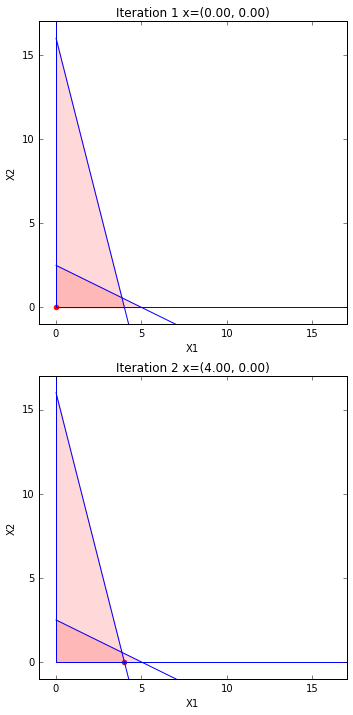

In [29]:
A=np.array([[1,2],[2,0.5]])
b=np.array([5,8])
c=np.array([5,1])
x, best, n_iter = solve_lin_prog(A, b, c, draw=True)

In [30]:
print (u'Точка: ', x)
print (u'Ответ: ', best)
print (u'Число итераций: ', n_iter)

Точка:  [ 4.  0.]
Ответ:  20.0
Число итераций:  2


In [31]:
is_optimal(A,b,c,x)

True

## Еще пример

In [32]:
A = np.array([[2, 3, 1], [4, 1, 2], [3, 4, 2]])
c = np.array([5, 4, 3])
b = np.array([5, 11, 8])

x, best, n_iter = solve_lin_prog(A, b, c)

In [33]:
print (u'Точка: ', x)
print (u'Ответ: ', best)
print (u'Число итераций: ', n_iter)

Точка:  [ 2.  0.  1.]
Ответ:  13.0
Число итераций:  3


In [34]:
is_optimal(A,b,c,x)

True

# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------